In [1]:
using LinearAlgebra
using JLD2
using LaTeXStrings
using Plots; pyplot()
default(framestyle = :box)

In [3]:
# Problem generation and convenience functions

function data_generation(n,k,ratio)
    T = ceil(2 * k * log(n / k) + 1.25 * k + 1)
    m = Int(ratio * T)
    A = randn(m,n) / sqrt(m)

    xtrue = zeros(n,1)
    xtrue[1:k] = randn(k)
    normalize!(xtrue,2)

    b = A * xtrue

    r = 2 * sqrt(k)

    return A, b, xtrue, r
end

function f_oracle(A, b, xtrue, r, x)
    # first order oracle for:
    # |x|₁ + r |Ax - b|₂
    diff = A * x - b
    val = norm(x, 1) + r * norm(diff)

    grad = sign.(x)
    if norm(diff) > eps(Float64)
        normalize!(diff)
        grad += r * (A' * diff)
    end

    return val, grad
end

function mirror(n, θ)
    q = 1 + log(n)
    if norm(θ, q) < eps(Float64)
        return zeros(size(θ))
    else
        return sign_power.(θ, q - 1) ./ (norm(θ, q)^(q-2))
    end
end

function sign_power(x, p)
    return sign(x) * abs(x)^p
end

sign_power (generic function with 1 method)

In [4]:
# Algorithms

function polyak_rmd(A, b, xtrue, r; max_iters=10000, epsilon_cutoff=1e-10)
    opt_val = norm(xtrue, 1)
    errors = Float64[]
    
    n = size(xtrue)[1]
    L = 1 + 1.1 * r
    q = 1 + log(n)
    x̄ = zeros(n)
    ϵ0 = r * norm(b,2)

    xt = zeros(n)
    θt = zeros(n)
    push!(errors,norm(xt - xtrue,2))

    # k = 1
    ϵk = ϵ0 * exp(-1/2)
    ηk = ϵk / (log(n) * L^2)

    for t = 1:max_iters
        val, gradt = f_oracle(A, b, xtrue, r, xt)
        θt -= ηk * gradt
        xt = x̄ + mirror(n, θt)

        push!(errors,norm(xt - xtrue,2))
        if norm(xt - xtrue,1) < epsilon_cutoff
            break
        end

        if val - opt_val <= ϵk
            # k = k+1
            ϵk *= exp(-1/2)
            ηk = ϵk / (log(n) * L^2)
            x̄ .= xt
            θt = zeros(n)
        end
    end

    return errors
end

function polyak_gd(A, b, xtrue, r; max_iters=10000, epsilon_cutoff=1e-10)
    opt_val = norm(xtrue, 1)
    errors = Float64[]
    
    n = size(xtrue)[1]

    xt = zeros(n)
    push!(errors,norm(xt - xtrue,2))

    for t = 1:max_iters
        val, gradt = f_oracle(A, b, xtrue, r, xt)
        xt -= (val - opt_val) / norm(gradt)^2 * gradt

        push!(errors,norm(xt - xtrue,2))
        if norm(xt - xtrue,1) < epsilon_cutoff
            break
        end
    end

    return errors
end

polyak_gd (generic function with 1 method)

In [5]:
# tests

pows = [3,4,5,6] # n = 10^pow
k = 5;
ratio = 2;

results = Dict()
results["polyak-rmd"] = []
results["polyak-gd"] = []

for pow in pows
    n = Int(10^pow)

    A, b, xtrue, r = data_generation(n,k,ratio);

    errors_rmd = polyak_rmd(A, b, xtrue, r; max_iters = 100000);
    errors_gd = polyak_gd(A, b, xtrue, r; max_iters = 100000);

    push!(results["polyak-rmd"], errors_rmd)
    push!(results["polyak-gd"], errors_gd)
end

jldsave("./results/experiment.jld2";
    pows = pows,
    k=k,
    ratio=ratio,
    results=results)

Log-Log Plot for polyak-rmd


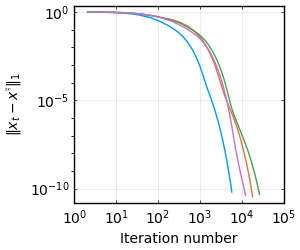

Log-Log Plot for polyak-gd


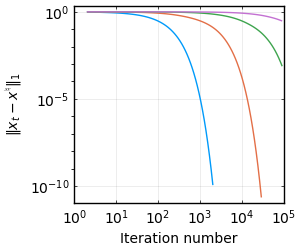

Log Plot for polyak-rmd


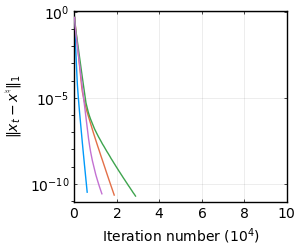

Log Plot for polyak-gd


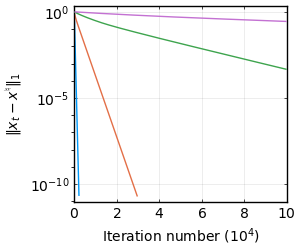

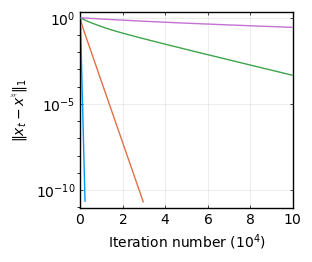

In [24]:
# Plotting

colors = palette(:default)[1:length(pows)]'

exp_spacing=1.1    
idxs = unique(Int.(round.([exp_spacing^k for k = 1:Int(round(log2(10^5)/log2(exp_spacing)))])))

for alg in ["polyak-rmd", "polyak-gd"]
    Plots.plot()
    for (i, pow) in enumerate(pows)
        dists = results[alg][i]

        iters = [i for i in idxs if i <= length(dists)]
        dists = dists[[i for i in idxs if i <= length(dists)]]

        Plots.plot!(
            iters .+ 1, # hack to play well with log scale 
            dists,
            lw=1.0, linecolor=colors[i],
            label=latexstring("n = 10^", pow))
    end

    xlabel!("Iteration number")
    ylabel!(L"\|x_t - x^\natural\|_1")

    xaxis!(:log10)
    yaxis!(:log10)

    println("Log-Log Plot for " * alg)
    display(Plots.plot!(xtickfontsize=10, xguidefontsize=10, ytickfontsize=10, yguidefontsize=10,leg=false, size=(300,250), xlims=(1,10^5)))
    Plots.savefig("./results/loglog_" * alg * ".pdf")
end

linear_spacing=100
idxs = [linear_spacing * i for i = 1:10^4]

for alg in ["polyak-rmd","polyak-gd"]
    Plots.plot()
    for (i, pow) in enumerate(pows)
        dists = results[alg][i]

        iters = [i for i in idxs if i <= length(dists)] ./ 10^4
        dists = dists[[i for i in idxs if i <= length(dists)]]

        Plots.plot!(
            iters, # hack to play well with log scale 
            dists,
            lw=1.0, linecolor=colors[i],
            label=latexstring("n = 10^", pow))
    end

    xlabel!(latexstring("Iteration number (\$10^4\$)"))
    ylabel!(L"\|x_t - x^\natural\|_1")
    
    yaxis!(:log10)

    println("Log Plot for " * alg)
    display(Plots.plot!(xtickfontsize=10, xguidefontsize=10, ytickfontsize=10, yguidefontsize=10,leg=false, size=(300,250), xticks=[0,2,4,6,8,10], xlims=(0,10)))

    Plots.savefig("./results/log_" * alg * ".pdf")
end